In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.sparse import csr_matrix
from numba import njit

# Get the parent directory (go up one level)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Define the path to the library (inside the parent directory)
library_path = os.path.join(parent_dir, "")
# Add to sys.path if not already there
if library_path not in sys.path:
    sys.path.append(library_path)
library_path
import mmars
print(library_path)

c:\Users\rasmu\Documents\GitHub\MMARS\


## Setup a simulation environment

In [2]:
radar_model_1 = mmars.FmcwRadar(position=np.array([[0,0]]),N_chirps=1, signalNoiseRatio=[200,10])
radar_model_1_cpy = radar_model_1

target_model_1 = mmars.Target(start_position=np.array([[10,10]]), start_velocity=5., T_total=15., T_frame=0.1)
target_model_1.generate_trajectory(trajectory_type="sinusoidal")
target_model_1_ground_truth = target_model_1.get_trajectory()

simulation = mmars.Simulation(radar_model_1, target_model_1)
simulation.run()

Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x000002D7B23D7550> and <mmars.target.Target object at 0x000002D7F375CB90>


100%|██████████| 150/150 [00:00<00:00, 1034.12it/s]


## Define the MRBLaT algorithm

The MRBLaT algorithm should minimise the Kullback-lieber divergence defined as

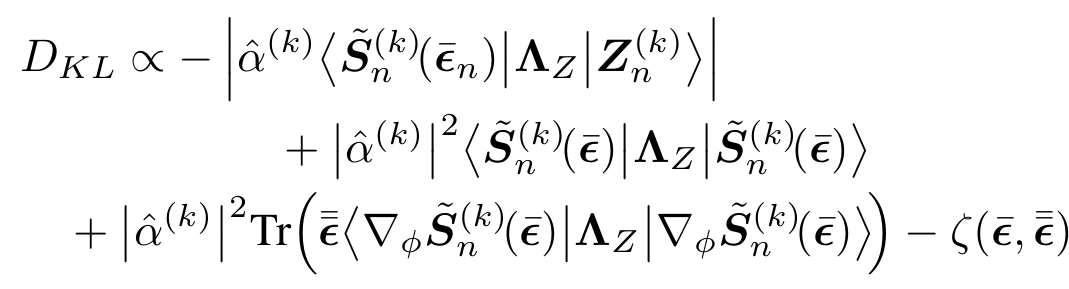


### Defining the loss factor $\alpha$
The loss factor $\alpha$ is defined as 

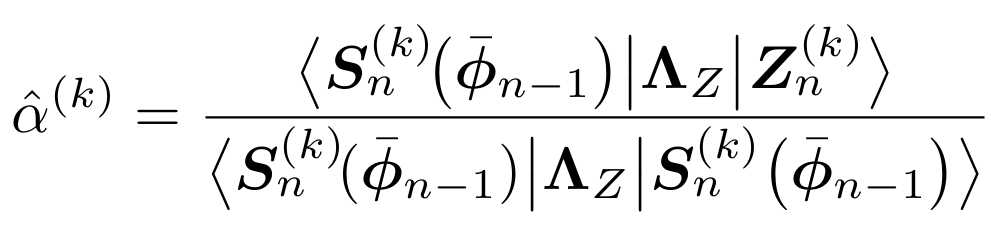

where the previous estimate is used to calculate $\alpha$.

In [3]:
def CALC_LOSS_FACTOR(LAST_POSITION : np.ndarray, LAMBDA_Z : np.ndarray, CURRENT_DATA_FRAME : np.ndarray, RADAR_MODEL_CPY):
    RADAR_MODEL_CPY.generate_S_signal(target_x=LAST_POSITION[0,0], target_y=LAST_POSITION[0,1])
    S_BASED_ON_LAST_POSITION = RADAR_MODEL_CPY.get_S_signal(flatten=True)
    S_BASED_ON_LAST_POSITION_H = S_BASED_ON_LAST_POSITION.conj().T
    return (S_BASED_ON_LAST_POSITION_H @ LAMBDA_Z @ CURRENT_DATA_FRAME) / (S_BASED_ON_LAST_POSITION_H @ LAMBDA_Z @ S_BASED_ON_LAST_POSITION)

### Defining the first term of the $D_{KL}$

The first term of the $D_{KL}$ is defined as

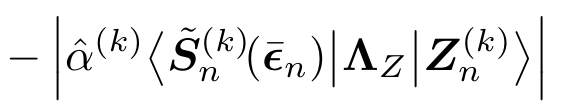

In [4]:
def CALC_FIRST_TERM(LOSS_FACTOR, S_N_H_LAMBDA_Z : np.ndarray, CURRENT_DATA_FRAME : np.ndarray):
    BRAKET = S_N_H_LAMBDA_Z@CURRENT_DATA_FRAME
    return - np.abs(LOSS_FACTOR * BRAKET)

### Defining the second term of the $D_{KL}$

The second term of the $D_{KL}$ is defined as

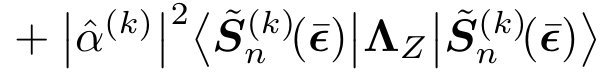

In [5]:
def CALC_SECOND_TERM(LOSS_FACTOR, S_N_H_LAMBDA_Z : np.ndarray, S_N : np.ndarray):
    BRAKET = S_N_H_LAMBDA_Z@S_N
    return np.abs(LOSS_FACTOR)**2 * BRAKET

### Defining the third term of the $D_{KL}$

The third term of the $D_{KL}$ is defined as

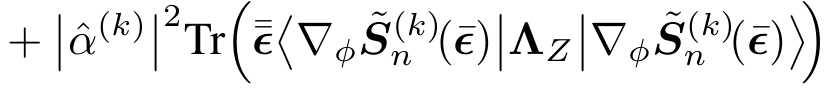

In [6]:
def CALC_THIRD_TERM(LOSS_FACTOR, PARAMS : np.ndarray, LAMBDA_Z : np.ndarray, S_N : np.ndarray):
    JAC = JACOBIAN(PARAMS[0], PARAMS[1])
    JAC_INNER_PRODUCT = JAC.T.conj() @ LAMBDA_Z @ JAC
    COV_MATRIX = np.array([[PARAMS[2], 0], [0, PARAMS[3]]])
    return np.abs(LOSS_FACTOR)**2 * np.trace(COV_MATRIX@JAC_INNER_PRODUCT)

@njit
def MAPLE_PARTIAL_DIFF(x,y, RADAR_ANTENNA_CONFIG,X_R, Y_R,N_SAMPLES,FREQS,CHRIP_RATE,F_SAMPLING,C,WAVELENGTH_C,GAIN,TRANSMIT_POWER,RCS,jjj):
    X_TX = RADAR_ANTENNA_CONFIG[0]
    Y_TX = RADAR_ANTENNA_CONFIG[1]
    X_RX = RADAR_ANTENNA_CONFIG[2]
    Y_RX = RADAR_ANTENNA_CONFIG[3]

    t1 = x - X_R
    t2 = t1 ** 2
    t4 = (y - Y_R) ** 2
    t5 = t2 + t4
    t6 = np.sqrt(t5)
    t8 = 0.1e1 / t6 * CHRIP_RATE
    t9 = 0.1e1 / C
    t10 = 0.1e1 / F_SAMPLING
    t14 = N_SAMPLES + 1
    t18 = t10 * np.pi * t9 * t6 * CHRIP_RATE
    t22 = t14 * (FREQS - 4 * t18) / 2
    t23 = np.cos(t22)
    t27 = FREQS / 2 - 2 * t18
    t28 = np.sin(t27)
    t29 = 0.1e1 / t28
    t34 = np.exp(-jjj * FREQS * N_SAMPLES / 2)
    t36 = x - X_TX
    t37 = t36 ** 2
    t39 = (y - Y_TX) ** 2
    t41 = np.sqrt(t37 + t39)
    t42 = x - X_RX
    t43 = t42 ** 2
    t45 = (y - Y_RX) ** 2
    t47 = np.sqrt(t43 + t45)
    t49 = 0.1e1 / WAVELENGTH_C
    t53 = np.exp(2 * t49 * (t41 + t47) * jjj * np.pi)
    t56 = WAVELENGTH_C ** 2
    t57 = t56 * GAIN * TRANSMIT_POWER
    t60 = t5 ** 2
    t64 = np.sqrt(0.1e1 / t60 / np.pi * RCS * t57)
    t65 = t64 * t53 * t34
    t69 = np.sin(t22)
    t70 = t28 ** 2
    t76 = np.cos(t27)
    t81 = t29 * t69
    t95 = np.pi ** 2
    t108 = -t65 * t29 * t23 * t14 * t1 * t10 * t9 * t8 / 4 + t76 * t1 * t10 * t9 * t8 * t65 / t70 * t69 / 4 + t64 * t53 * t49 * (2 * t36 / t41 + 2 * t42 / t47) * jjj * t34 * t81 / 8 - t1 / t5 / t60 * RCS * t57 / t64 / t95 * t53 * t34 * t81 / 4
    return t108

def JACOBIAN(X, Y, JACBOIAN_SOLVER = "MAPLE"):    
    N_SAMPLES = radar_model_1.get_N_samples()
    FREQS = np.linspace(0, 2 * np.pi, N_SAMPLES, endpoint=False)
    C = 3e8
    TX_ANTENNAS = radar_model_1.get_tx_antennas()
    RX_ANTENNAS = radar_model_1.get_rx_antennas()

    match JACBOIAN_SOLVER:
        case "MAPLE":
            
            JACOBIAN_RES = np.zeros((len(TX_ANTENNAS) * len(RX_ANTENNAS) * N_SAMPLES, 2), dtype=np.complex128)
            ITTERATION = 0
            for TX in TX_ANTENNAS:
                for RX in RX_ANTENNAS:
                    JACOBIAN_RES[ITTERATION*N_SAMPLES:(ITTERATION+1)*N_SAMPLES, 0] = MAPLE_PARTIAL_DIFF(X, Y, [TX[0], TX[1], RX[0], RX[1]], 
                                                                                                        radar_model_1.get_radar_position()[0,0], radar_model_1.get_radar_position()[0,1], 
                                                                                                        N_SAMPLES, FREQS, radar_model_1.get_chirp_rate(), 
                                                                                                        radar_model_1.get_sampling_frequency(), C, radar_model_1.get_wavelength(), 
                                                                                                        radar_model_1.get_antenna_gain(), radar_model_1.get_transmit_power(), radar_model_1.get_radar_cross_section(), 1j)
                    JACOBIAN_RES[ITTERATION*N_SAMPLES:(ITTERATION+1)*N_SAMPLES, 1] = MAPLE_PARTIAL_DIFF(Y, X, [TX[0], TX[1], RX[0], RX[1]], 
                                                                                                        radar_model_1.get_radar_position()[0,0], radar_model_1.get_radar_position()[0,1], 
                                                                                                        N_SAMPLES, FREQS, radar_model_1.get_chirp_rate(), 
                                                                                                        radar_model_1.get_sampling_frequency(), C, radar_model_1.get_wavelength(), 
                                                                                                        radar_model_1.get_antenna_gain(), radar_model_1.get_transmit_power(), radar_model_1.get_radar_cross_section(), 1j)
                    ITTERATION += 1
            return JACOBIAN_RES
        case _:
            raise ValueError("JACBOIAN_SOLVER not supported. Please use MAPLE.")
    

### Defining the entropy term of the $D_{KL}$

The entropy term of the $D_{KL}$ is defined as

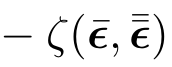

In [7]:
def CALC_ENTROPY():
    return -0

### Construct the $D_{KL}$ function

In [8]:
LAMBDA_Z = np.eye(3072) * (2.763854534117991e-7)**(-2)
LAMBDA_Z = csr_matrix(LAMBDA_Z)

def D_KL(PARAMS, CURRENT_DATA_FRAME, LAST_POSITION, RADAR_MODEL_CPY):
    
    RADAR_MODEL_CPY.generate_S_signal(target_x=PARAMS[0], target_y=PARAMS[1])
    S_N = RADAR_MODEL_CPY.get_S_signal(flatten=True)
    S_N_H_LAMBDA_Z = S_N.conj().T @ LAMBDA_Z

    LOSS_FACTOR = CALC_LOSS_FACTOR(LAST_POSITION, LAMBDA_Z, CURRENT_DATA_FRAME, RADAR_MODEL_CPY)
    FIRST_TERM = CALC_FIRST_TERM(LOSS_FACTOR, S_N_H_LAMBDA_Z, CURRENT_DATA_FRAME)
    SECOND_TERM = CALC_SECOND_TERM(LOSS_FACTOR, S_N_H_LAMBDA_Z, S_N)
    THIRD_TERM = CALC_THIRD_TERM(LOSS_FACTOR, PARAMS, LAMBDA_Z, S_N)
    ENTROPY = CALC_ENTROPY()
    
    return np.real(
        FIRST_TERM + SECOND_TERM + THIRD_TERM # + ENTROPY
    )

In [9]:
frame = 1
current_frame_fft_data = simulation.get_data(idx=frame,flatten=True,fft_data=True)
D_KL([5, 5, 0.1, 0.1], current_frame_fft_data[:,np.newaxis], np.array([[5,5]]), radar_model_1_cpy)

array([[3.22415478e+08]])

## Visualise the performance of the MRBLaT algorithm

### Plot the data, estimated data and jacobian

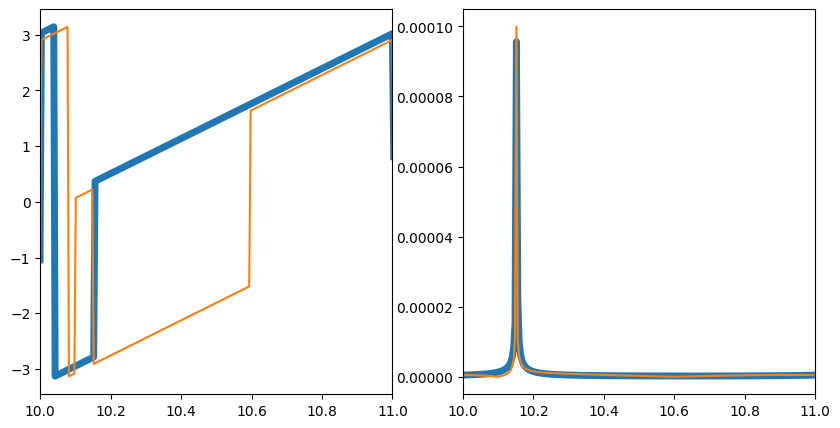

In [10]:
NS = radar_model_1.get_N_samples()*len(radar_model_1.get_rx_antennas())*len(radar_model_1.get_tx_antennas())
indecies = np.linspace(0, len(radar_model_1.get_rx_antennas())*len(radar_model_1.get_tx_antennas()), NS)
radar_model_1_cpy.generate_S_signal(target_x=target_model_1_ground_truth[0][frame], target_y=target_model_1_ground_truth[1][frame])

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(indecies, np.angle(current_frame_fft_data), label="Data", lw=5)
ax[0].plot(indecies, np.angle(radar_model_1_cpy.get_S_signal(flatten=True)), label="S_signal")

ax[1].plot(indecies, np.abs(current_frame_fft_data), label="Data", lw=5)
ax[1].plot(indecies, np.abs(radar_model_1_cpy.get_S_signal(flatten=True)), label="S_signal")
for axis in ax:
    axis.set_xlim(10, 11)

### 2D heat map of location estimate

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\rasmu\AppData\Local\Temp\ipykernel_31008\1767940950.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  heatmap_location[i,j] = D_KL([location_x_axis[i], location_y_axis[j], 0.1, 0.1], current_frame_fft_data[:,np.newaxis], np.array([[5,5]]), radar_model_1_cpy)
100%|██████████| 50/50 [00:05<00:00,  8.55it/s]


Lowest D_KL: (32243.247058261826+0j) at (50.0, 50.0)


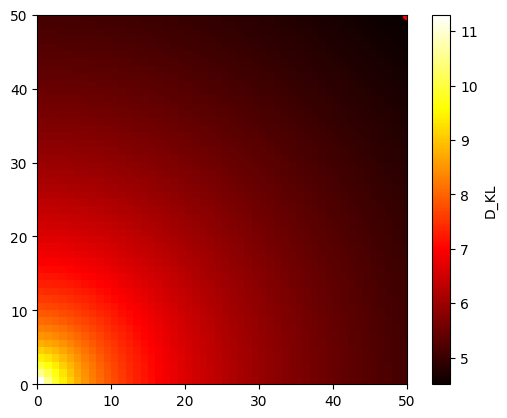

In [ ]:
heatmap_resolution = 50
location_x_axis = np.flip(np.linspace(50, 0, heatmap_resolution,endpoint=False))
location_y_axis = np.flip(np.linspace(50, 0, heatmap_resolution,endpoint=False))
heatmap_location = np.zeros((heatmap_resolution, heatmap_resolution), dtype=np.complex128)

for i in tqdm(range(heatmap_resolution)):
    for j in range(heatmap_resolution):
        heatmap_location[i,j] = D_KL([location_x_axis[i], location_y_axis[j], 0.1, 0.1], current_frame_fft_data[:,np.newaxis], np.array([[target_model_1_ground_truth[0][frame-1], target_model_1_ground_truth[1][frame-1]]]), radar_model_1_cpy)

plt.imshow(np.log10(np.abs(heatmap_location)), extent=(0, 50, 0, 50), origin='lower', cmap='hot')
plt.colorbar(label='D_KL')
min_value = np.min(heatmap_location)
min_index = np.unravel_index(np.argmin(heatmap_location), heatmap_location.shape)
min_x = location_x_axis[min_index[0]]
min_y = location_y_axis[min_index[1]]
plt.scatter(min_x, min_y, color='red', label='Lowest D_KL')
print(f"Lowest D_KL: {min_value} at ({min_x}, {min_y})")

### 2D heat map of estimation variances

Lowest D_KL: (32243.247058261826+0j) at (50.0, 50.0)


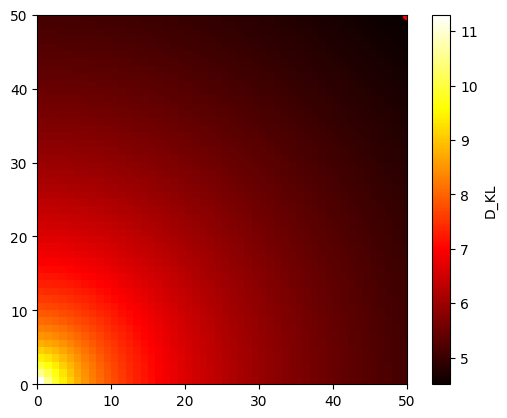

In [ ]:
location_x_axis = np.flip(np.linspace(10, 0, heatmap_resolution,endpoint=False))
location_y_axis = np.flip(np.linspace(10, 0, heatmap_resolution,endpoint=False))
heatmap_location = np.zeros((heatmap_resolution, heatmap_resolution), dtype=np.complex128)

for i in tqdm(range(heatmap_resolution)):
    for j in range(heatmap_resolution):
        heatmap_location[i,j] = D_KL([target_model_1_ground_truth[0][frame], target_model_1_ground_truth[1][frame], 0.1, 0.1], current_frame_fft_data[:,np.newaxis], np.array([[target_model_1_ground_truth[0][frame-1], target_model_1_ground_truth[1][frame-1]]]), radar_model_1_cpy)

plt.imshow(np.log10(np.abs(heatmap_location)), extent=(0, 50, 0, 50), origin='lower', cmap='hot')
plt.colorbar(label='D_KL')
min_value = np.min(heatmap_location)
min_index = np.unravel_index(np.argmin(heatmap_location), heatmap_location.shape)
min_x = location_x_axis[min_index[0]]
min_y = location_y_axis[min_index[1]]
plt.scatter(min_x, min_y, color='red', label='Lowest D_KL')
print(f"Lowest D_KL: {min_value} at ({min_x}, {min_y})")